# Importing Packages

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# --------------------------------------------------------------------------------------

### Creating annotations for each image - food class and bounding box - Not normalized

In [2]:
def mapping_image_id_to_bbox(annotations_json_file_path: str):
    """
    This function return a dict, a key is an image id, and the value
    is the food classes and bbox present in the image.
    """
    with open(annotations_json_file_path, "r") as file:
        annotations_json_file = json.load(file)
    
    dct = {}
    for annotation in annotations_json_file["annotations"]:
        image_id = annotation["image_id"]
        food_class = annotation["category_id"]
        bbox = annotation["bbox"]
        if image_id not in dct:
            dct[image_id] = []
        bbox.insert(0,food_class)
        dct[image_id].append(bbox)
    return dct

In [3]:
def doJob(data_path):
    """
    This function creats a text file for each image in the dataset and put
    the annotations(not normalized) inside this text
    """
    annotations_json_file_path = data_path+"/annotations.json"
    image_id_to_annotations = mapping_image_id_to_bbox(annotations_json_file_path)
    for image in os.listdir(data_path+"/images"):
        image_name = os.path.splitext(os.path.basename(data_path+"images/"+image))[0]
        image_id = int(image_name)
        
        annotation_txt_file_path = data_path+"/annotations-not-normalized/"+image_name+".txt"
        with open(annotation_txt_file_path, "w") as file:
            for annotation in image_id_to_annotations[image_id]:
                file.write(" ".join(map(str, annotation)) + "\n")  # Write annotations

In [41]:
# Create annotations for the images in public_validation_set_2
doJob("../data/external/public_validation_set_2.0")

# Create annotations for the images in public_training_set_release_2.0
doJob("../data/external/public_training_set_release_2.0")

# --------------------------------------------------------------------------------------

### Create a Json file to map the food class ids to new ids

- Every food class will have an id between 0 and 497

In [6]:
with open("../data/external/food_classes_with_original_id.json", "r") as file:
    food_class_to_original_id = json.load(file)

In [7]:
food_class_to_original_id["jam"]

2099

In [4]:
with open("../data/external/food_classes.txt", "r") as file:
    food_classes = file.read()
food_classes = food_classes.split("\n")

In [9]:
food_classes[:9]

['bread-wholemeal',
 'jam',
 'water',
 'bread-sourdough',
 'banana',
 'soft-cheese',
 'ham-raw',
 'hard-cheese',
 'cottage-cheese']

In [10]:
id = 0
original_id_to_new_id = {}

for food_class in food_classes:
    if food_class in food_class_to_original_id:
        original_id = food_class_to_original_id[food_class]
        original_id_to_new_id[original_id] = {}
        original_id_to_new_id[original_id]["name"] = food_class
        original_id_to_new_id[original_id]["new_id"] = id
        id+=1

In [11]:
with open("../data/external/original_id_to_new_id.json", "w") as file:
    json.dump(original_id_to_new_id, file, indent=4) 

# --------------------------------------------------------------------------------------

### Change the food class id to the new id in the annotations text files

In [21]:
def change_ids(data_dir_path):
    for annotation in os.listdir(data_dir_path):
        annotation_file_path = os.path.join(data_dir_path, annotation)

        with open(annotation_file_path, "r") as file:
            lines = file.readlines()

        updated_lines = []
        for line in lines:
            values = line.strip().split()
            original_id = int(values[0])  # Extract the class ID
            if original_id in original_id_to_new_id:
                new_id = original_id_to_new_id[original_id]["new_id"]
                values[0] = str(new_id)  # Replace the class ID
            updated_lines.append(" ".join(values))  # Reconstruct the line

        # Write the updated annotations back to the file
        with open(annotation_file_path, "w") as file:
            file.write("\n".join(updated_lines))

In [22]:
change_ids("../data/external/public_validation_set_2.0/annotations")

In [23]:
change_ids("../data/external/public_training_set_release_2.0/annotations")

# --------------------------------------------------------------------------------------

### Visualize some images alongside their annotations (bboxes and food classes)

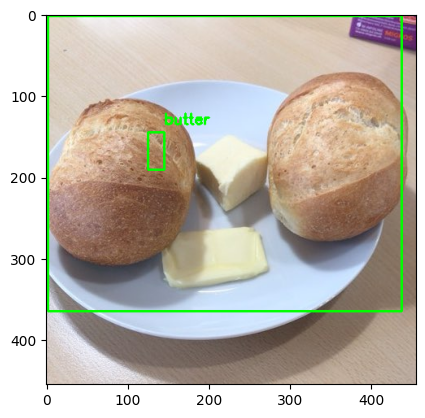

In [11]:
# Data path
data_path = "../data/external/public_validation_set_2.0"
images_list = os.listdir(data_path + "/images")

# Select a random image
random_int = random.randint(0, len(images_list) - 1)
image_path = data_path + "/images/" + images_list[random_int]
image_name = os.path.splitext(os.path.basename(image_path))[0]

# Load the image
image = cv2.imread(image_path)

# Read the annotation file
annotation_txt_file_path = data_path + "/annotations-not-normalized/" + image_name + ".txt"
with open(annotation_txt_file_path, "r") as file:
    annotation_lines = file.readlines()

# Loop through each bounding box annotation
for line in annotation_lines:
    data = line.strip().split()
    class_id = int(data[0])  # Class ID
    y_min, x_min, y_max, x_max = map(float, data[1:])  # BBox values (y, x format)

    # Convert to integer coordinates
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    #print( x_min, y_min, x_max, y_max )

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Put the class name
    class_name = food_classes[class_id]  # Get class name from the list
    cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [33]:
height, width, _ = image.shape

In [49]:
annotation_lines

['43 20.718292541503907 20.718292541503907 243.39159469604493 346.86500000000007\n',
 '117 218.9973872375488 226.23079254150392 115.50340530395513 157.39249999999996']

41 72 658 780


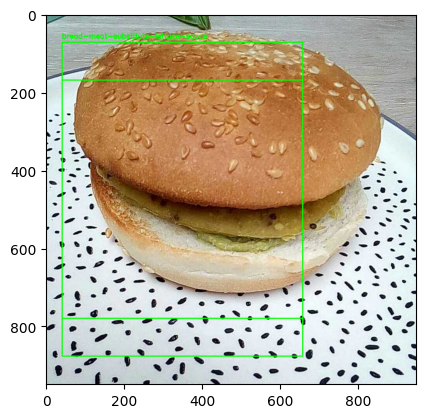

In [35]:
print( x_min, y_min, x_max, y_max )

# Draw the bounding box
cv2.rectangle(image, (x_min, height-y_max), (x_max, height-y_ma), (0, 255, 0), 2)

# Put the class name
class_name = food_classes[class_id]  # Get class name from the list
cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [32]:
image.shape

(949, 949, 3)

In [48]:
food_classes[117]

'kiwi'

In [46]:
class_id

117

In [6]:
#!pip install opencv-python